In [23]:
import pandas as pd
import numpy as np
import requests 
import json

In [8]:
df = pd.read_csv('./data/buildings.csv')

In [9]:
# 누락컬럼 제거
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'])
df.head()

,신고일,철거멸실/처리 구분,철거멸실일,취소구분,취소일,존치기간,대지위치,대지면적(㎡),건축면적(㎡),연면적(㎡),용도,기타용도,구조,기타구조,동수
0,20221229,NaN,NaN,NaN,NaN,20241226.0,충청남도 부여군 홍산면 조현리 471-2 외 1필지,1136.0,36.00,36.00,가설건축물,저온저장고,컨테이너조,NaN,2
1,20221229,NaN,NaN,NaN,NaN,20251229.0,충청남도 부여군 규암면 합송리 28-12,3860.0,16.50,16.50,가설건축물,저온저장고,조립식판넬조,NaN,1
2,20221229,NaN,NaN,NaN,NaN,20251225.0,충청남도 부여군 내산면 운치리 508-7,727.2,53.03,53.03,가설건축물,저온창고,컨테이너조,NaN,2
3,20221227,NaN,NaN,NaN,NaN,20251226.0,충청남도 부여군 남면 신홍리 323,856.0,10.40,10.40,가설건축물,저온저장고,조립식판넬조,조립식판넬조,1
4,20221226,NaN,NaN,NaN,NaN,20251130.0,충청남도 부여군 석성면 비당리 산 11-224,8331.0,18.00,18.00,가설건축물,산지관리사,컨테이너조,NaN,1


In [10]:
# 필요한 컬럼만 선별
df_clean = df.drop(columns=['대지면적(㎡)', '건축면적(㎡)', '연면적(㎡)', '용도', '구조', '기타구조', '동수'])
df_clean.head()

,신고일,철거멸실/처리 구분,철거멸실일,취소구분,취소일,존치기간,대지위치,기타용도
0,20221229,NaN,NaN,NaN,NaN,20241226.0,충청남도 부여군 홍산면 조현리 471-2 외 1필지,저온저장고
1,20221229,NaN,NaN,NaN,NaN,20251229.0,충청남도 부여군 규암면 합송리 28-12,저온저장고
2,20221229,NaN,NaN,NaN,NaN,20251225.0,충청남도 부여군 내산면 운치리 508-7,저온창고
3,20221227,NaN,NaN,NaN,NaN,20251226.0,충청남도 부여군 남면 신홍리 323,저온저장고
4,20221226,NaN,NaN,NaN,NaN,20251130.0,충청남도 부여군 석성면 비당리 산 11-224,산지관리사


In [11]:
# 존치기간이 명시되지 않은 행 삭제
df_clean = df_clean.dropna(axis=0, subset=['존치기간'])

In [12]:
# 존치기간을 실질적철거일로 명시
df_clean['실질적철거일'] = df_clean['존치기간'].astype(int)
df_clean.head()

,신고일,철거멸실/처리 구분,철거멸실일,취소구분,취소일,존치기간,대지위치,기타용도,실질적철거일
0,20221229,NaN,NaN,NaN,NaN,20241226.0,충청남도 부여군 홍산면 조현리 471-2 외 1필지,저온저장고,20241226
1,20221229,NaN,NaN,NaN,NaN,20251229.0,충청남도 부여군 규암면 합송리 28-12,저온저장고,20251229
2,20221229,NaN,NaN,NaN,NaN,20251225.0,충청남도 부여군 내산면 운치리 508-7,저온창고,20251225
3,20221227,NaN,NaN,NaN,NaN,20251226.0,충청남도 부여군 남면 신홍리 323,저온저장고,20251226
4,20221226,NaN,NaN,NaN,NaN,20251130.0,충청남도 부여군 석성면 비당리 산 11-224,산지관리사,20251130


In [13]:
# 철거일자 확실한 항목들을 실질적철거일로 지정
df_clean.loc[df_clean['철거멸실일'] == '철거', '실질적철거일'] = df_clean.loc[df['철거멸실일'] == '철거', '철거멸실일']

In [14]:
# 취소일자가 존재하고 존치기간보다 취소일자가 빠른 항목들은 취소일자를 실질적철거일로 지정
df_clean.loc[(df_clean['취소구분'] == '취소') & (df_clean['취소일'] < df_clean['존치기간']), '실질적철거일'] = df_clean.loc[(df_clean['취소구분'] == '취소') & (df_clean['취소일'] < df_clean['실질적철거일']), '취소일']

In [15]:
# 필요한 컬럼만 선별
df_clean = df_clean.loc[:, ['신고일', '실질적철거일', '대지위치', '기타용도']]
df_clean.head()

,신고일,실질적철거일,대지위치,기타용도
0,20221229,20241226,충청남도 부여군 홍산면 조현리 471-2 외 1필지,저온저장고
1,20221229,20251229,충청남도 부여군 규암면 합송리 28-12,저온저장고
2,20221229,20251225,충청남도 부여군 내산면 운치리 508-7,저온창고
3,20221227,20251226,충청남도 부여군 남면 신홍리 323,저온저장고
4,20221226,20251130,충청남도 부여군 석성면 비당리 산 11-224,산지관리사


In [16]:
# 2012.01.01 이전 철거된 구조물 제거하기
df_clean = df_clean[df_clean['실질적철거일'] > 20111231]

In [19]:
# 주소 정제하기
df_clean['정제주소'] = df_clean['대지위치'].astype(str).map(
    lambda x: ' '.join(x.split(' ')[:-2]) if x.split(' ')[-2] == '외' else ' '.join(x.split(' ')[:])
)
df_clean.head()

,신고일,실질적철거일,대지위치,기타용도,정제주소
0,20221229,20241226,충청남도 부여군 홍산면 조현리 471-2 외 1필지,저온저장고,충청남도 부여군 홍산면 조현리 471-2
1,20221229,20251229,충청남도 부여군 규암면 합송리 28-12,저온저장고,충청남도 부여군 규암면 합송리 28-12
2,20221229,20251225,충청남도 부여군 내산면 운치리 508-7,저온창고,충청남도 부여군 내산면 운치리 508-7
3,20221227,20251226,충청남도 부여군 남면 신홍리 323,저온저장고,충청남도 부여군 남면 신홍리 323
4,20221226,20251130,충청남도 부여군 석성면 비당리 산 11-224,산지관리사,충청남도 부여군 석성면 비당리 산 11-224


In [24]:
# 주소 컬럼을 정제주소 컬럼으로 대체
df_clean = df_clean.loc[:, ['신고일', '실질적철거일', '정제주소', '기타용도']]
df_clean.head()

,신고일,실질적철거일,정제주소,기타용도
0,20221229,20241226,충청남도 부여군 홍산면 조현리 471-2,저온저장고
1,20221229,20251229,충청남도 부여군 규암면 합송리 28-12,저온저장고
2,20221229,20251225,충청남도 부여군 내산면 운치리 508-7,저온창고
3,20221227,20251226,충청남도 부여군 남면 신홍리 323,저온저장고
4,20221226,20251130,충청남도 부여군 석성면 비당리 산 11-224,산지관리사


In [239]:
# 기타용도를 균사, 창고, 축사로 분류하며 이외의 것은 다 제거
df_clean.loc[df_clean['기타용도'] == '표고버섯재배사 ', '기타용도'] = '균사'
df_clean.loc[df_clean['기타용도'] == '창고형', '기타용도'] = '창고'
df_clean.loc[df_clean['기타용도'] == '축사용 임시창고', '기타용도'] = '축사'
df_clean = df_clean.drop(df_clean.loc[df_clean['기타용도'] == '하역장'].index)

In [245]:
df_clean['기타용도'].value_counts()

창고    2071
축사     199
균사      13
Name: 기타용도, dtype: int64

In [244]:
df_clean.to_csv('./data/building_v2.csv', encoding='utf-8-sig', index=False)

In [246]:
# 카카오맵 API 키 불러오기
API_KEY = 'c8d2487b6ee1ee531c4b6899126efe7f'
headers = {'Authorization' : 'KakaoAK '+API_KEY}
headers

{'Authorization': 'KakaoAK c8d2487b6ee1ee531c4b6899126efe7f'}

In [247]:
# 카카오맵 API 경도, 위도 함수 정의
def getLat(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['y'])

def getLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['x'])

In [249]:
# 정제주소로 위도, 경도 계산
df_addr = df_clean[['정제주소']]
df_addr.head()

,정제주소
0,충청남도 부여군 홍산면 조현리 471-2
1,충청남도 부여군 규암면 합송리 28-12
2,충청남도 부여군 내산면 운치리 508-7
3,충청남도 부여군 남면 신홍리 323
5,충청남도 부여군 규암면 반산리 297-6


In [250]:
# 카카오 api로 주소를 위도 경도로 변환
error = []
for i in df_addr.index:
    try:
        lng = getLng(df_addr['정제주소'][i])
        lat = getLat(df_addr['정제주소'][i])
        df_addr.loc[i,['경도']] = lng
        df_addr.loc[i,['위도']] = lat

    except:
        print('error',i)
        error.append(i)
        
    
    if i%100 == 0:
        print('{} 번째 주소에 대한 좌표정보 불러오는 중...'.format(i)) 

0 번째 주소에 대한 좌표정보 불러오는 중...
100 번째 주소에 대한 좌표정보 불러오는 중...
error 168
400 번째 주소에 대한 좌표정보 불러오는 중...
600 번째 주소에 대한 좌표정보 불러오는 중...
error 715
error 751
800 번째 주소에 대한 좌표정보 불러오는 중...
1000 번째 주소에 대한 좌표정보 불러오는 중...
error 1002
1100 번째 주소에 대한 좌표정보 불러오는 중...
1200 번째 주소에 대한 좌표정보 불러오는 중...
error 1243
error 1245
1300 번째 주소에 대한 좌표정보 불러오는 중...
error 1336
error 1363
1400 번째 주소에 대한 좌표정보 불러오는 중...
1500 번째 주소에 대한 좌표정보 불러오는 중...
error 1536
1600 번째 주소에 대한 좌표정보 불러오는 중...
error 1693
1700 번째 주소에 대한 좌표정보 불러오는 중...
error 1751
1800 번째 주소에 대한 좌표정보 불러오는 중...
1900 번째 주소에 대한 좌표정보 불러오는 중...
2100 번째 주소에 대한 좌표정보 불러오는 중...
2200 번째 주소에 대한 좌표정보 불러오는 중...
error 2205
error 2289
error 2297
2300 번째 주소에 대한 좌표정보 불러오는 중...
2400 번째 주소에 대한 좌표정보 불러오는 중...
error 2429
2500 번째 주소에 대한 좌표정보 불러오는 중...
error 2501
error 2507
error 2571
2600 번째 주소에 대한 좌표정보 불러오는 중...
error 2616
2700 번째 주소에 대한 좌표정보 불러오는 중...
error 2733
error 2791
2800 번째 주소에 대한 좌표정보 불러오는 중...
error 2817
error 2842
2900 번째 주소에 대한 좌표정보 불러오는 중...
3000 번째 주소에 대한 좌표정보 불러오는 중...
error 3

In [336]:
# 위도 및 경도 변환 실패한 주소
df_addr.loc[error]

,정제주소,경도,위도
168,충청남도 부여군 은산면 홍산리 18-7,NaN,NaN
715,충청남도 부여군 규암면 나복리 575-2,NaN,NaN
751,충청남도 부여군 장암면 점상리 산 150-5,NaN,NaN
1002,충청남도 부여군 구룡면 주정리 산 119-2,NaN,NaN
1243,충청남도 부여군 규암면 합송리 산 1013-3,NaN,NaN
1245,충청남도 부여군 석성면 석성리 112-3,NaN,NaN
1336,충청남도 부여군 석성면 현내리 255,NaN,NaN
1363,충청남도 부여군 남면 삼용리 176-1,NaN,NaN
1536,충청남도 부여군 내산면 금지리 71-8,NaN,NaN
1693,충청남도 부여군 구룡면 논티리 208-7,NaN,NaN


In [338]:
# 원래 데이터프레임으로 경도, 위도 복사
df_clean['경도'] = df_addr['경도']
df_clean['위도'] = df_addr['위도']
df_clean.head()

,신고일,실질적철거일,정제주소,기타용도,경도,위도
0,20221229,20241226,충청남도 부여군 홍산면 조현리 471-2,창고,126.788844,36.233691
1,20221229,20251229,충청남도 부여군 규암면 합송리 28-12,창고,126.859276,36.266739
2,20221229,20251225,충청남도 부여군 내산면 운치리 508-7,창고,126.778802,36.271223
3,20221227,20251226,충청남도 부여군 남면 신홍리 323,창고,126.791335,36.198915
5,20221226,20251222,충청남도 부여군 규암면 반산리 297-6,창고,126.861835,36.271202


In [340]:
# 주소가 존재하지 않는 행들을 제외
df_clean = df_clean.dropna(subset=['경도', '위도'])

In [343]:
# 필요한 컬럼만 선별
df_clean = df_clean.loc[:, ['신고일', '실질적철거일', '경도', '위도', '기타용도']]
df_clean.head()

,신고일,실질적철거일,경도,위도,기타용도
0,20221229,20241226,126.788844,36.233691,창고
1,20221229,20251229,126.859276,36.266739,창고
2,20221229,20251225,126.778802,36.271223,창고
3,20221227,20251226,126.791335,36.198915,창고
5,20221226,20251222,126.861835,36.271202,창고


In [344]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [345]:
# 위도, 경도 15, 15 좌표계로 변환
df_clean['x'] = df_clean['경도'].astype(float).map(lambda x: np.trunc((x - LEFT) / ((RIGHT - LEFT) / 15.)))
df_clean['y'] = df_clean['위도'].astype(float).map(lambda x: np.trunc((x - LOWER) / ((UPPER - LOWER) / 15.)))
df_clean.head()

,신고일,실질적철거일,경도,위도,기타용도,x,y
0,20221229,20241226,126.788844,36.233691,창고,4.0,7.0
1,20221229,20251229,126.859276,36.266739,창고,6.0,9.0
2,20221229,20251225,126.778802,36.271223,창고,3.0,9.0
3,20221227,20251226,126.791335,36.198915,창고,4.0,6.0
5,20221226,20251222,126.861835,36.271202,창고,7.0,9.0


In [347]:
# 필요한 컬럼만 선별
df_clean = df_clean.loc[:, ['신고일', '실질적철거일', 'x', 'y', '기타용도']]
df_clean.head()

,신고일,실질적철거일,x,y,기타용도
0,20221229,20241226,4.0,7.0,창고
1,20221229,20251229,6.0,9.0,창고
2,20221229,20251225,3.0,9.0,창고
3,20221227,20251226,4.0,6.0,창고
5,20221226,20251222,7.0,9.0,창고


In [348]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

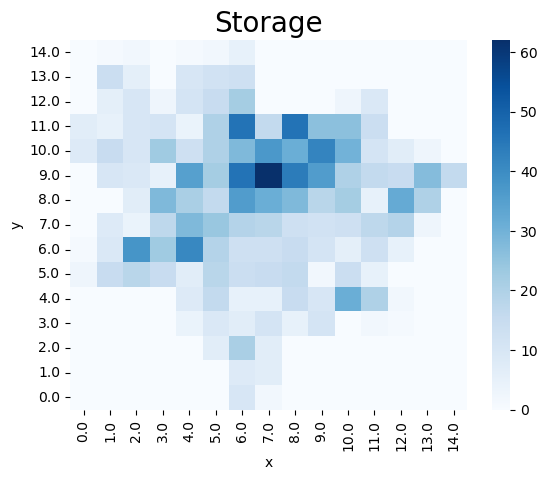

In [361]:
# 전체기간동안의 창고 위치 시각화
df_storage = df_clean.loc[df_clean['기타용도'] == '창고', ['x', 'y', '기타용도']].groupby(['x', 'y']).count().reset_index()
storage_heatmap = df_storage.pivot('y', 'x', '기타용도').sort_index(ascending=False).fillna(0)
ax = sns.heatmap(storage_heatmap, cmap='Blues')
plt.title('Storage', fontsize=20)
plt.show()

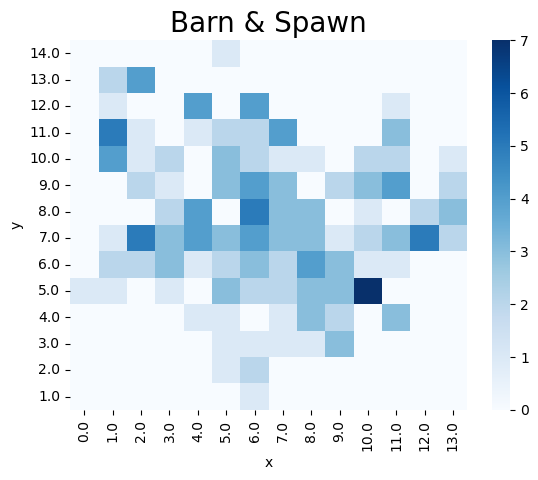

In [368]:
# 전체기간동안의 축사 및 균사 위치 시각화
df_barn_spawn = df_clean.loc[(df_clean['기타용도'] == '축사') | (df_clean['기타용도'] == '균사'), ['x', 'y', '기타용도']].groupby(['x', 'y']).count().reset_index()
barn_spawn_heatmap = df_barn_spawn.pivot('y', 'x', '기타용도').sort_index(ascending=False).fillna(0)
ax = sns.heatmap(barn_spawn_heatmap, cmap='Blues')
plt.title('Barn & Spawn', fontsize=20)
plt.show()

In [369]:
# 전처리한 데이터 저장
df_clean.to_csv('./data/preprocessed_buildings.csv', encoding='utf-8-sig', index=False)